In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Noto Serif SC'
plt.rcParams['font.sans-serif'] = ['Noto Serif SC']

In [2]:
from data_process import X_train, X_test, y_train, y_test
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

Path to dataset files: /home/tibless/.cache/kagglehub/datasets/drsaeedmohsen/ucihar-dataset/versions/1/UCI-HAR Dataset
X_train 形状: (7352, 9, 128)
y_train 形状: (7352, 6)
X_test  形状: (2947, 9, 128)
y_test  形状: (2947, 6)
(7352, 9, 128)
(7352, 6)
(2947, 9, 128)
(2947, 6)


In [3]:
def deone_hot(x):
    return np.argmax(x, axis=1)

y_test_proba = y_test
y_train_proba = y_train
y_test = deone_hot(y_test)
y_train = deone_hot(y_train)

In [4]:
y2name = [
    'Walking',
    'Walking Upstairs',
    'Walking Downstairs',
    'Sitting',
    'Standing',
    'Lying Down',
]

x2name = [
    'body_acc_x',
    'body_acc_y',
    'body_acc_z',
    'body_gyro_x',
    'body_gyro_y',
    'body_gyro_z',
    'total_acc_x',
    'total_acc_y',
    'total_acc_z',
]

# Train

In [141]:
def shiyan1(X, y_true, y_pred, num, hide_raw=False, random=True, ix=None):
    ix = ix
    if random:
        ix = np.random.randint(X_train.shape[0])
    
    seq = X[ix]
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 10))
    
    axs = axs.ravel()
    
    ylim = [
        (-1, 1), (-1, 1), (-1, 1),
        (-1, 1), (-1, 1), (-1, 1),
        (-1, 2), (-1, 1), (-1, 1),
    ]
    
    for i, ax in enumerate(axs):
        subseq = seq[i]  # len: 128
    
        # one = subseq[::2]
        # two = subseq[1::2]
        # # ax.scatter(range(0, 128, 2), even, s=7, color='g')
        # ax.plot(range(0, 128, 2), even,label=f'{x2name[i]} even')
        # # ax.scatter(range(1, 128, 2), odd, s=7, color='r')
        # ax.plot(range(1, 128, 2), odd,label=f'{x2name[i]} odd')
        if not hide_raw:
            xx = [subseq[ix::1] for ix in range(1)]
            for j, subsubseq in enumerate(xx):
                ax.plot(range(j, 128, 1), xx[j], label=f'{x2name[i]}, raw', color='r')
     
        
        xx = [subseq[ix::num] for ix in range(num)]
        for j, subsubseq in enumerate(xx):
            ax.plot(range(j, 128, num), xx[j], label=f'{x2name[i]}:{j}')
            
        
        
        # ax.scatter(range(subseq.shape[0]), subseq, s=5, color='r')  # total
        # ax.plot(range(subseq.shape[0]), subseq ,label=f'{x2name[i]}')
        # ax.set_xlabel(f'time steps')
        # ax.set_ylabel(f'value')
    
        ax.tick_params(axis='x', direction='in')
        ax.tick_params(axis='y', direction='in')
        # ax.set_ylim(ylim[i][0], ylim[i][1])
        ax.legend()

    if y_true[ix] == y_pred[ix]:
        plt.suptitle(f'✓ Label: {y2name[y_true[ix]]} → {y2name[y_pred[ix]]}', fontsize=20)
    else:
        plt.suptitle(f'╳ Label: {y2name[y_true[ix]]} → {y2name[y_pred[ix]]}', fontsize=20)
    fig.tight_layout()
    plt.show()

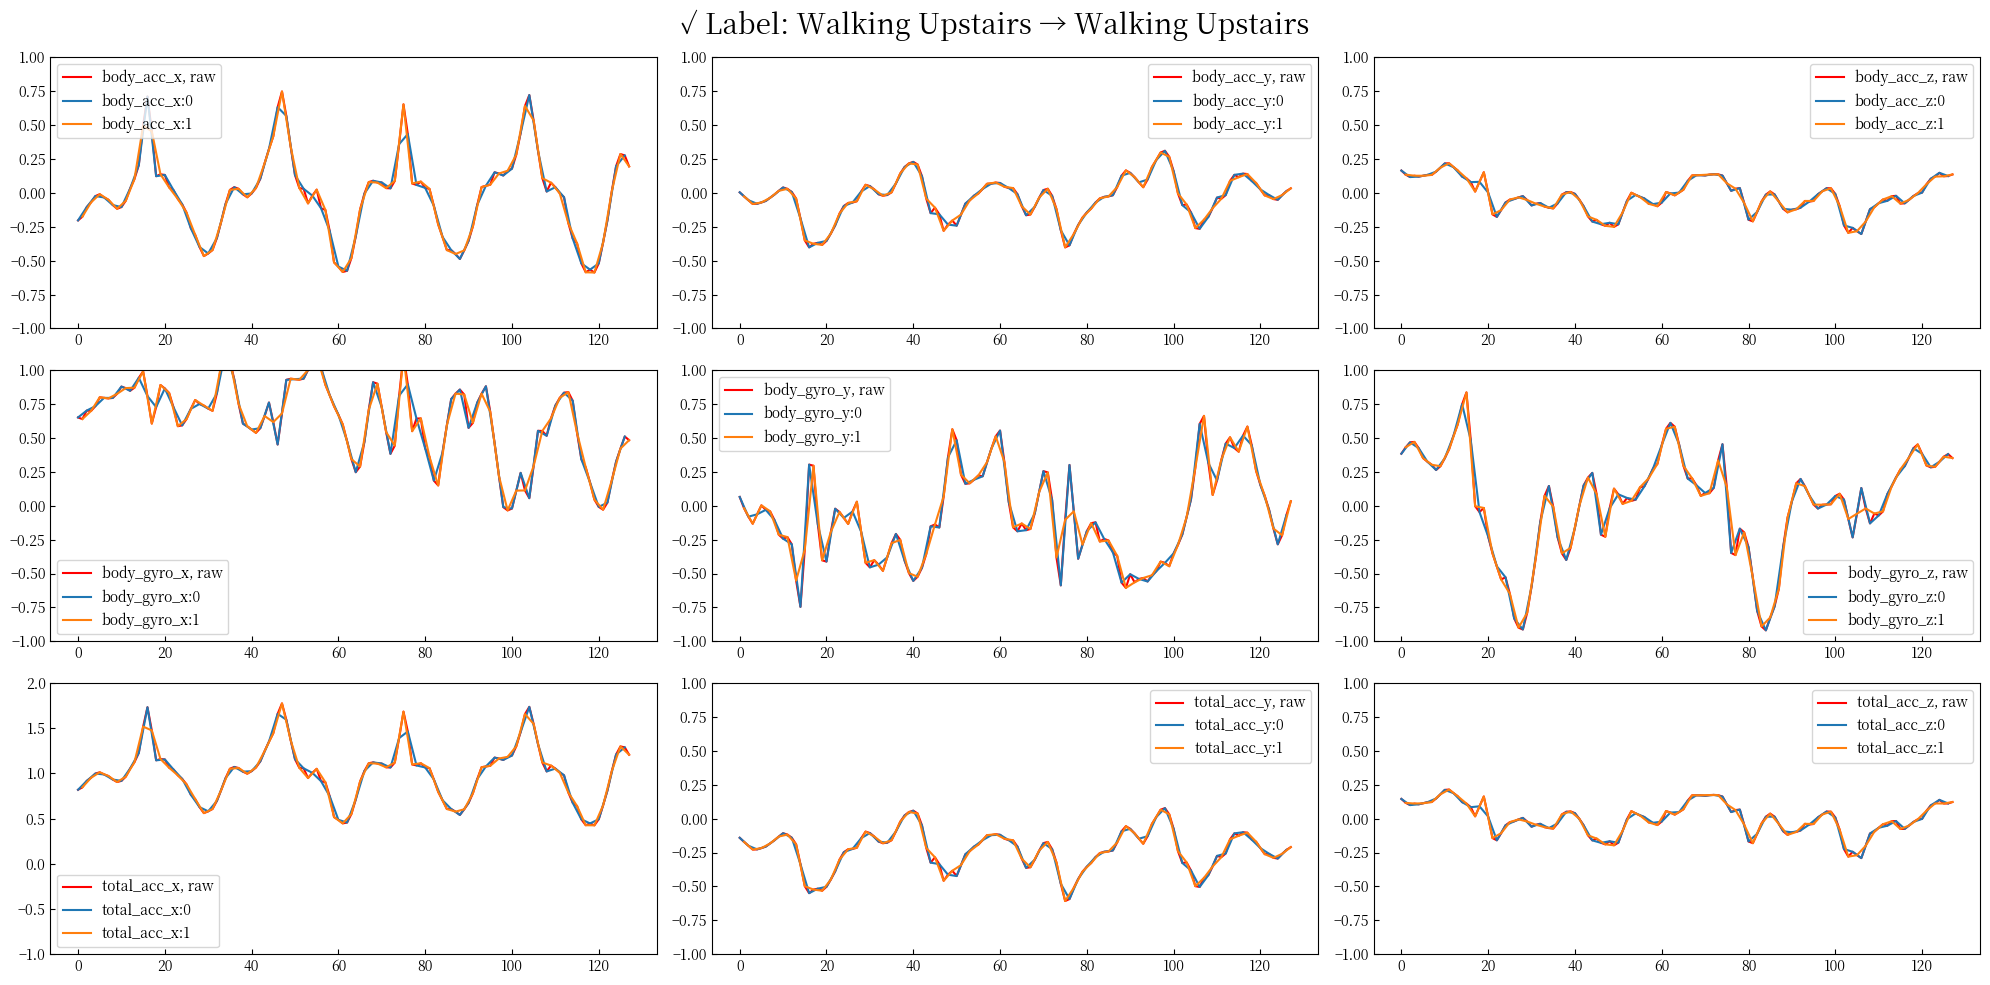

In [108]:
shiyan1(X_train, y_train, y_train, num=2, hide_raw=False)

In [11]:
from jax import random
import jax.numpy as jnp

from plugins.minitorch.nn import Model, Rnn, Dense
from plugins.minitorch.loss import CrossEntropyLoss
from plugins.minitorch.initer import Initer
from plugins.minitorch.optimizer import Adam
from plugins.minitorch.utils import softmax

key = random.PRNGKey(42)

class GRU(Model):
    def __init__(self, lr, epoches, batch_size):
        super().__init__(lr=lr, epoches=epoches)

        self.config = {
            'gru:0': Rnn.get_gru(128, 9, 64),
            'fc:0': Dense.get_linear(64, 6),
        }

        initer = Initer(self.config, key)
        self.optr = Adam(initer(), lr=lr, batch_size=batch_size)
        self.lossr = (self.predict_proba)

    def predict_proba(self, x, params, train=True):
        res = jnp.transpose(x, (2, 0, 1))
        res, _ = Rnn.gru(res, params['gru:0'], self.config['gru:0'])
        res = res[-1]

        res = Dense.linear(res, params['fc:0'])

        return softmax(res)

In [12]:
epochs = 200
batch_size = 64
learning_rate = 0.005

model = GRU(lr=learning_rate, epoches=epochs, batch_size=batch_size)
acc, loss, tacc, tloss = model.fit(
    x_train=X_train,
    y_train_proba=y_train_proba,
    x_test=X_test,
    y_test_proba=y_test_proba,
)

[*] oprimizer opened with 114 batches with batch size 64.
>> epoch: 10, train acc: 0.958242654800415, train loss: 0.10605863481760025; test acc: 0.9178826212882996, test loss: 0.2866766154766083
>> epoch: 20, train acc: 0.951441764831543, train loss: 0.08555462956428528; test acc: 0.9066847562789917, test loss: 0.46057945489883423
>> epoch: 30, train acc: 0.9776931405067444, train loss: 0.05076848715543747; test acc: 0.904988169670105, test loss: 0.5661478638648987
>> epoch: 40, train acc: 0.9673557877540588, train loss: 0.05196348577737808; test acc: 0.8920936584472656, test loss: 0.7387476563453674
>> epoch: 50, train acc: 0.9794613718986511, train loss: 0.051003843545913696; test acc: 0.9087207317352295, test loss: 0.4376879930496216
>> epoch: 60, train acc: 0.910908579826355, train loss: 0.2979808747768402; test acc: 0.8286393284797668, test loss: 0.6843863129615784
>> epoch: 70, train acc: 0.9451849460601807, train loss: 0.16013504564762115; test acc: 0.8639294505119324, test loss

In [142]:
key = random.PRNGKey(24)
selected = random.choice(key, jnp.arange(X_test.shape[0]), shape=(10,), replace=False)

test_x = X_test[selected]
test_y = y_test[selected]
print(test_x.shape)
print(test_y.shape)

(10, 9, 128)
(10,)


In [143]:
y_pred = model.predict_proba(test_x, model.optr.get_params(), train=False)
pred_y = jnp.argmax(y_pred, axis=1)
print(f'predict: {pred_y.tolist()}')
print(f'true   : {test_y.tolist()}')

predict: [1, 4, 0, 0, 4, 3, 0, 1, 1, 1]
true   : [1, 4, 0, 0, 3, 3, 0, 1, 1, 1]


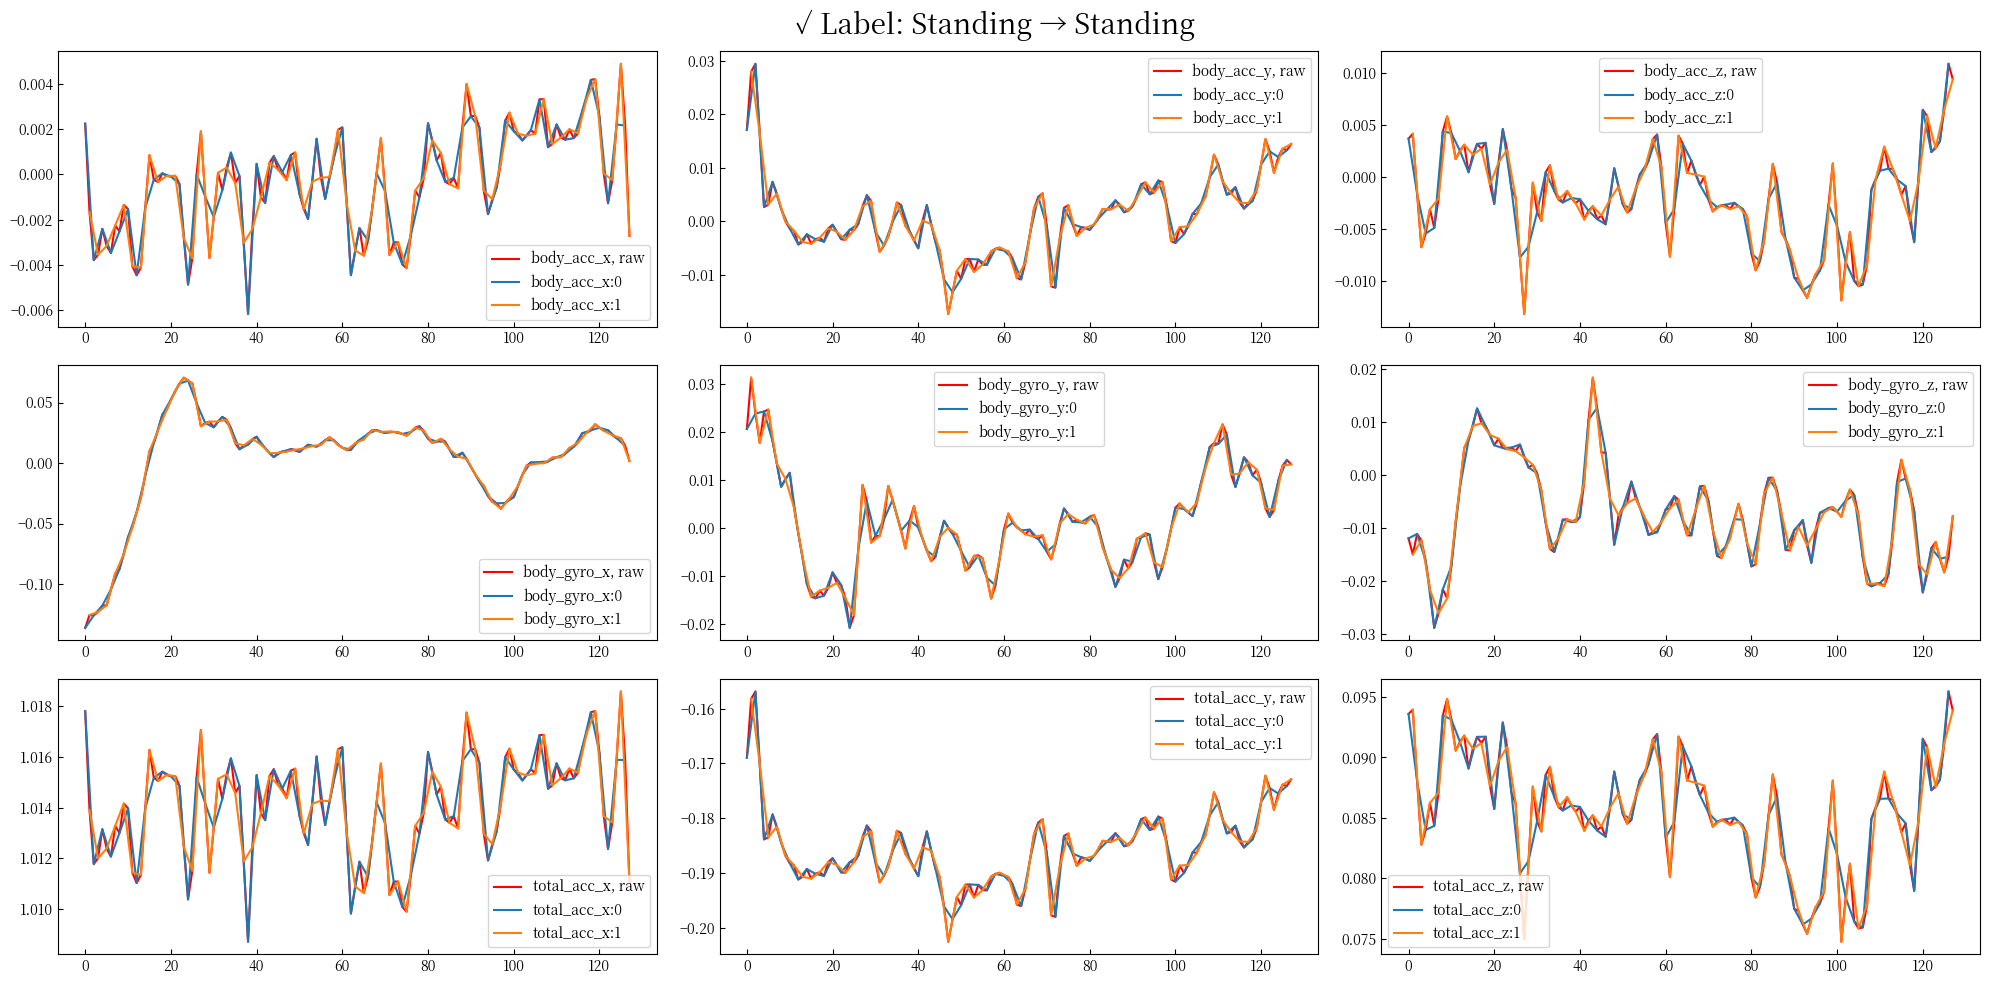

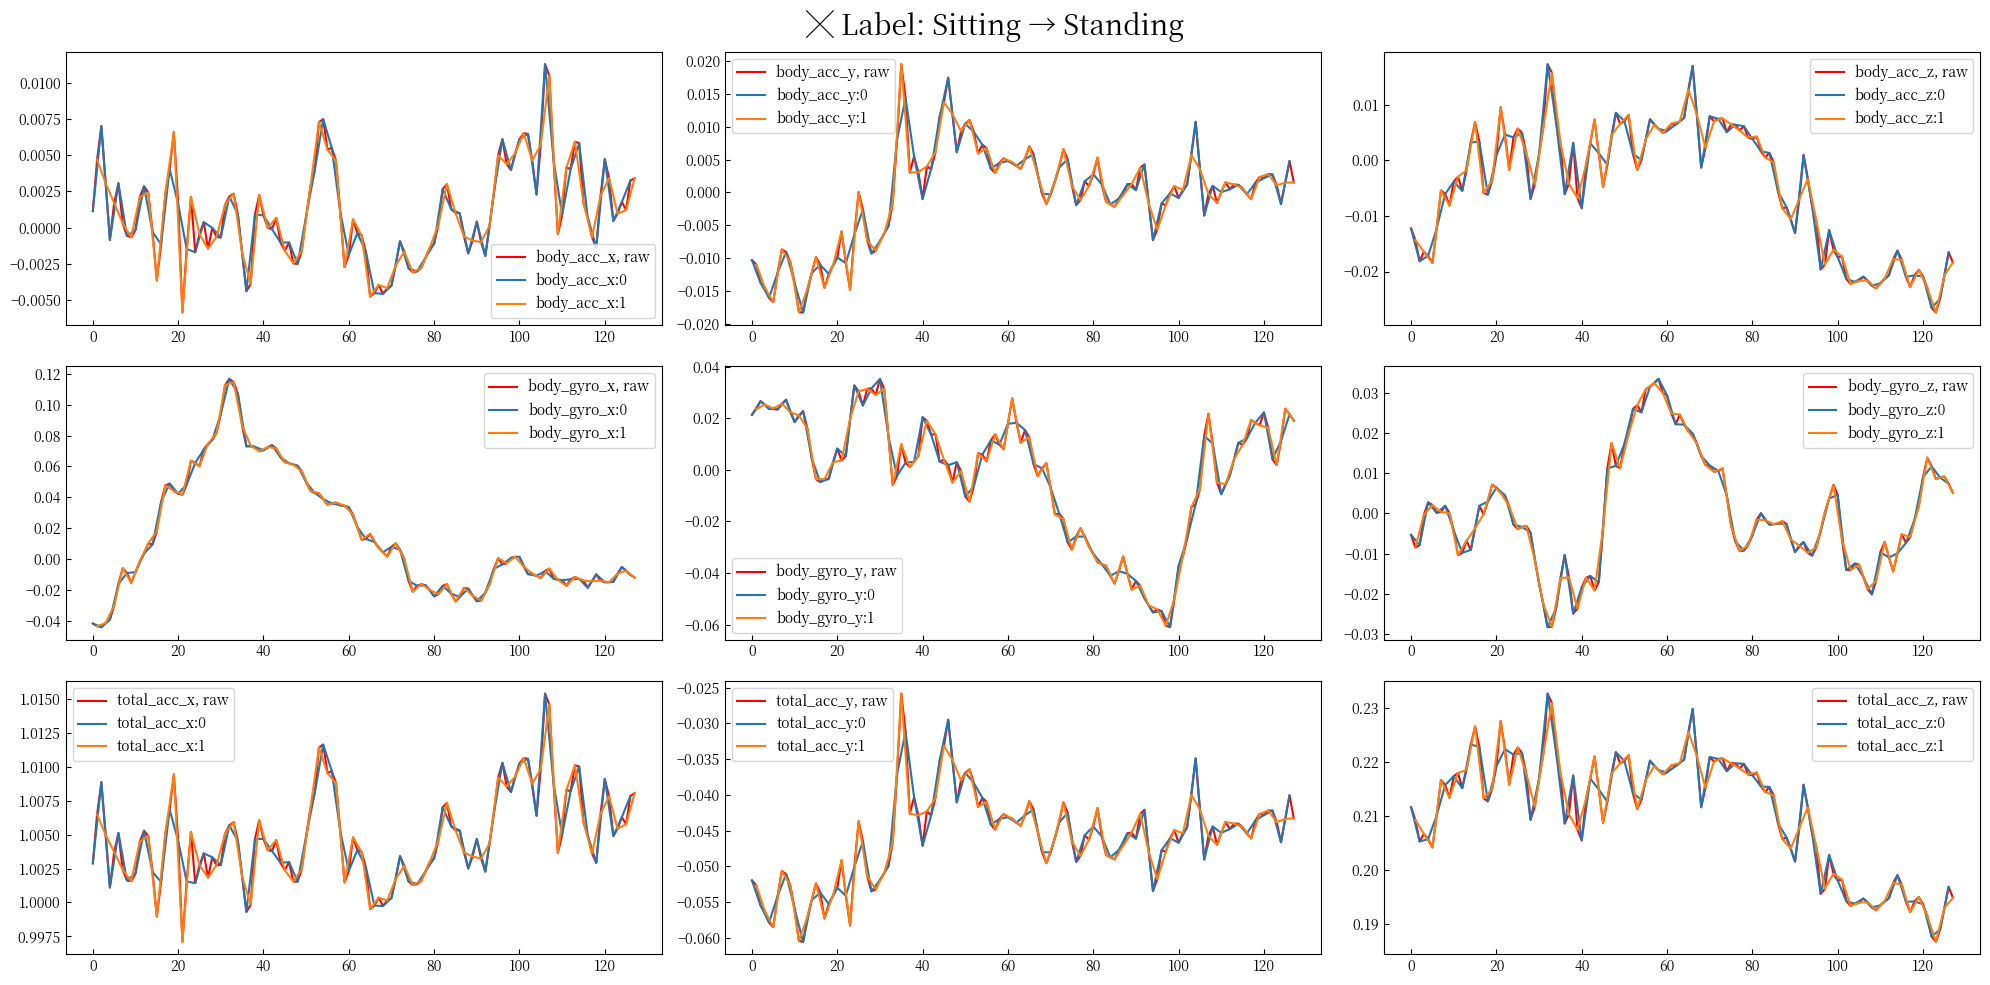

In [144]:
for ix in range(10):
    if pred_y[ix] == 4:
        shiyan1(X_test, test_y, pred_y,num=2, random=False, ix=ix)